In [1]:
#Fast Forward Moving Picture Experts Group (Service Audio Processing)
%%capture
!pip install ffmpeg-python

In [2]:
# access some utils files 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
PATH = "/content/drive/MyDrive/Speech-to-text task"


In [6]:
# Script file for rendering html with recording 
with open(PATH + "/utils/audio_script.html", "r", encoding='utf-8') as f:
    AUDIO_HTML = f.read()

In [7]:
import numpy as np
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

def get_audio():
    display(HTML(AUDIO_HTML))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])

    process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, err = process.communicate(input=binary)

    riff_chunk_size = len(output) - 8
    # Break up the chunk size into four bytes, held in b.
    q = riff_chunk_size
    b = []
    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
    riff = output[:4] + bytes(b) + output[8:]

    sr, audio = wav_read(io.BytesIO(riff)) # sample rate

    return audio, sr

In [174]:
import os
import re
import scipy

def add_wav_file_to_path(audio,sr, audio_name = None):
    """
    Add .wav file from audio, sr
    """
    all_files = os.listdir(PATH + '/sample')
    
    if audio_name:
        scipy.io.wavfile.write(PATH + f'/sample/{audio_name}.wav', sr, audio)
        print(f'file {audio_name}.wav was added')
        return None

    if all_files:
        all_count = [int(re.split('_|\.',i)[1]) for i in all_files]
        max_ = max(all_count)

    else:
        max_ = 0
    scipy.io.wavfile.write(PATH + f'/sample/record_{max_+1}.wav', sr, audio)
    print(f'file record_{max_+1}.wav was added')

    return None

In [69]:
import matplotlib.pyplot as plt

def display_wav_file(audio,sr):
    plt.figure(figsize=(20,10))
    plt.plot(audio)
    plt.suptitle(f"sample rate : {sr}")
    plt.show()

file record_11.wav was added


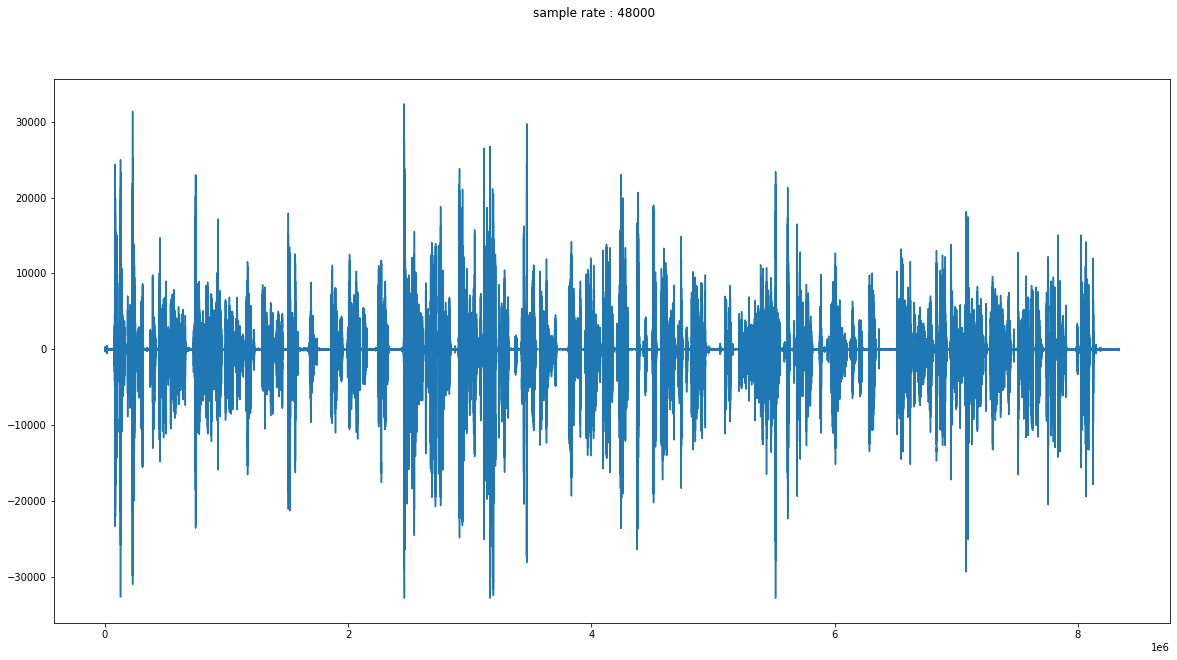

In [83]:
# Get, record, display the audio file

audio, sr = get_audio() 
add_wav_file_to_path(audio,sr) 
display_wav_file(audio,sr)

right now, your folder directory should be

Speech-to-text task

```
Speech-to-text task 
│
└───utils
│   │   audio_script.html
|   |
|
└───sample
    │   record_1.wav
    |.  record_2.wav
    │   ... (if record more)
```

In [168]:
%%capture
!pip install transformers

In [138]:
import torchaudio
from transformers import Wav2Vec2Processor,Wav2Vec2ForCTC

# processor, model 
processor = Wav2Vec2Processor.from_pretrained("airesearch/wav2vec2-large-xlsr-53-th")
model = Wav2Vec2ForCTC.from_pretrained("airesearch/wav2vec2-large-xlsr-53-th")

# function to resample to 16_000
def speech_file_to_array_fn(audio_path,truth = None, resampling_to=16000):
    
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(sampling_rate, resampling_to)

    speech = resampler(speech_array)[0].numpy()
    sampling_rate = resampling_to
    target_text = truth
    return speech, sampling_rate, target_text

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.9/dist-packages/transformers/configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [159]:
def predict(speech,processor,model):
    inputs = processor(speech, sampling_rate=16000,return_tensors="pt")

    with torch.no_grad():
        logits = model(inputs.input_values,).logits #185 features
    globals()['logits'] = logits
    predicted_ids = torch.argmax(logits, dim=-1)

    print("Prediction:", processor.batch_decode(predicted_ids))
    #print("Reference:", test_dataset["sentence"][:2])

In [181]:
num_record = 4 #@param {type:"slider", min:1, max:11, step:1}
audio_file_test= PATH + f'/sample/record_{num_record}.wav'

speech, sampling_rate, target_text = speech_file_to_array_fn(audio_file_test)

In [185]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [187]:
count_parameters(processor)

AttributeError: ignored

In [186]:
count_parameters(model)

315510470

In [182]:
predict(speech,processor,model)

Prediction: ['คุณ บอก ครับ ว่า นี้ ผม ถ่ายดำ มาก เลย   ผม จะ เป็น มะเร็ง ลบไซ เรีอ ข่าว  ครับ']




---



file test.wav was added


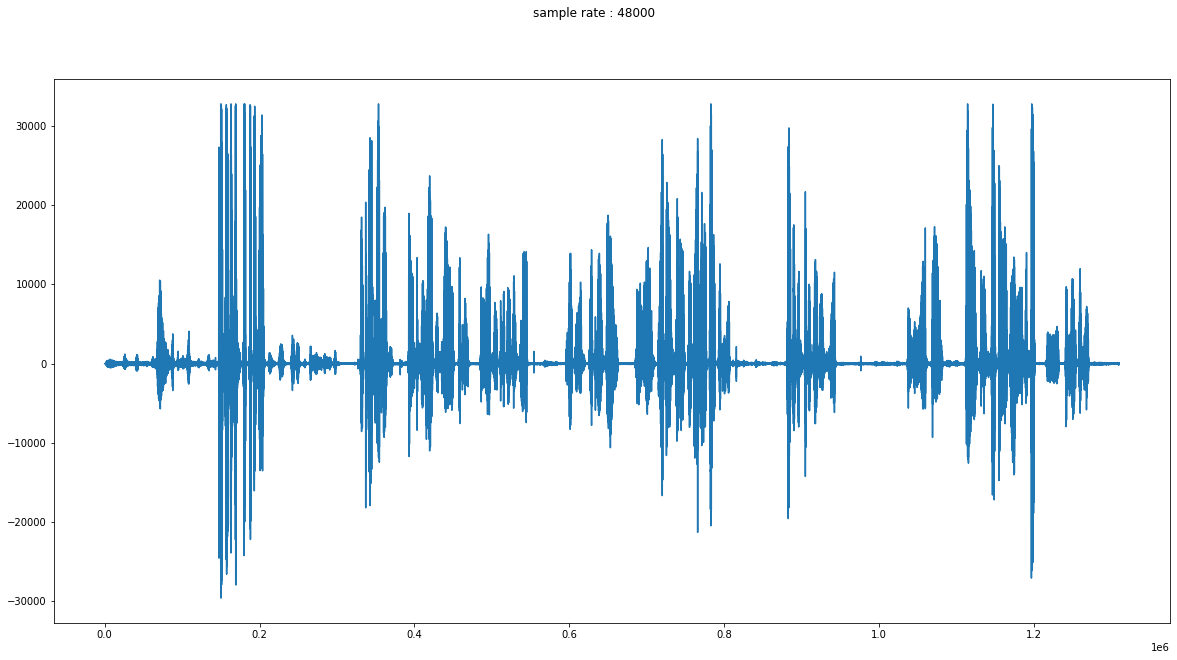

Prediction: ['พี่ พี พีกว่า สตอบ แต่ต ตนแลกโอเค คะ  ผม   อาน สมสดิ ค้าฟ คนไข้   วัว นี่ อา อาการ เป็น ย่างไง บ้าง ครับ   มี อาการ ปวด ท้อง ไมย   อา มี อาการอ่ จิ ไอ เอริเต ท มั้ย ครับ   การ ได้ยิน เป็น อยังไง บ้าง ครับอ่อ   อ่ะ   เรา อาน สายตา วิชัว เอฟเฟกต์ มีปัญหา ม้ย ครับ']


In [178]:
audio, sr = get_audio() 
add_wav_file_to_path(audio,sr,'test') 
display_wav_file(audio,sr)
speech, _, _ = speech_file_to_array_fn(PATH + '/sample/test.wav')
predict(speech,processor,model)